In [1]:
import chess.pgn
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import io
import polars as pl
import chess.engine
import pandas as pd

# VERI ÇEKME-DÜZENLEME İŞLEMİ

In [2]:
engine = chess.engine.SimpleEngine.popen_uci("stockfish/stockfish-macos-m1-apple-silicon")
board = chess.Board()

In [3]:
def moves_to_vector(game):
    board = game.board()
    moves = []
    for move in game.mainline_moves():
        moves.append(board.san(move))
        board.push(move)
    return moves

In [4]:
# PGN dosyasını açma
pgn_file_path = "Carlsen.pgn"
pgn_file = open(pgn_file_path)

# Tüm oyunları yükleme ve bir DataFrame'e aktarma
games = []
while True:
    game = chess.pgn.read_game(pgn_file)
    if game is None:
        break
    games.append(game)

pgn_file.close()

In [5]:
def classify_game_phase(move_count, piece_count, pawn_count):
    if move_count <= 15:
        return "Opening"
    elif piece_count <= 14:
        return "Endgame"
    elif piece_count <= 18 and pawn_count >=10 :
        return "Endgame"
    else:
        return "Middlegame"

In [23]:
def is_sacrifice(board, move, prev_evaluation, curr_evaluation, captured_piece, moving_piece):
    piece_values = {chess.PAWN: 1, chess.KNIGHT: 3, chess.BISHOP: 3, chess.ROOK: 5, chess.QUEEN: 9, chess.KING:999}
    
    #captured_piece = board.piece_at(move.to_square)
    #moving_piece = board.piece_at(move.from_square)
    
    if captured_piece is not None and moving_piece is not None:
        # Check if the captured piece is of higher value
        if piece_values[captured_piece.piece_type] < piece_values[moving_piece.piece_type]:
            # Check for significant drop in evaluation
            evaluation_drop = prev_evaluation - curr_evaluation
            #if evaluation_drop > 0.4:
            #    return True
            print("*********** Sacrifice ************")
            print("Captured: ",captured_piece)
            print(type(captured_piece))
            print(captured_piece.piece_type)
            print("Moving: ",moving_piece)
            print(moving_piece.piece_type)
            return True
    return False

In [6]:
def classify_game(game_evaluations):
    #Balanced: Neither player had an advantage.
    #Sharp: A back and forth game where both players had chances
    #Sudden: A close game that was lost by the mistake
    #Smooth: One player took the advantage and never let go
    
    evaluation_diff = np.diff(game_evaluations)
    max_diff = np.max(np.abs(evaluation_diff))
    avg_diff = np.mean(np.abs(evaluation_diff))
    std_dev = np.std(game_evaluations)
    final_evaluation = game_evaluations[-1]

    print("Max_diff:",max_diff)
    print("avg_diff:",avg_diff)
    print("Std:",std_dev)

    if max_diff < 0.2 and avg_diff <= 0.1:
        return "Balanced"
    elif max_diff > 0.5 and avg_diff > 0.1 and std_dev > 0.2:
        return "Sharp"
    elif max_diff > 0.4 and avg_diff <= 0.1:
        return "Sudden"
    elif (final_evaluation > 0.7 and np.mean(game_evaluations[-5:]) > 0.7) or (final_evaluation < 0.3 and np.mean(game_evaluations[-5:]) < 0.3):
        return "Smooth"
    else:
        return "Sharp"

In [7]:
# DataFrame oluşturma
evaluation_data = []
game_data = []
wdl_data = []

game_counter = 0

for game in games:
    board = chess.Board()
    

    game_counter+=1
    print()
    print("********** GAME",game_counter,"**********")
    # Oyun Sayısını belirliyor 100 oyun için çalışacak
#    if game_counter >= 2:
#        break
    
    game_info = {
        "Event": game.headers.get("Event", ""),
        "Site": game.headers.get("Site", ""),
        "Date": game.headers.get("Date", ""),
        "White": game.headers.get("White", ""),
        "Black": game.headers.get("Black", ""),
        "Result": game.headers.get("Result", ""),
        "ECO": game.headers.get("ECO"),
        "White Elo": game.headers.get("WhiteElo"),
        "Black Elo": game.headers.get("BlackElo"),
        "Moves": " ".join(moves_to_vector(game))
    }

    best_move = chess.Move.from_uci('e2e4')
    best_move_count = 0
    game_evaluations = []
    wdl_expectations = []
    
    for move in game.mainline_moves():
        #_move = chess.Move.from_uci(move)
        board.push(move)
        
        if move == best_move:
            best_move_count += 1
            
        # Tahtayı motora gönder ve değerlendirmeyi al
        info = engine.analyse(board, chess.engine.Limit(time=0.1))  # Zaman sınırlaması 0.1 saniye

        try:
            best_move = info["pv"][0]
        except KeyError:
            print('That was a last move.')
        
        evaluation = info["score"].relative.score()
        mate_in = info["score"].relative.mate()

        wdl_expectation = info["score"].white().wdl().expectation()
        wdl_expectations.append(wdl_expectation)
        
        if evaluation is not None:
            if board.turn == chess.BLACK:
                evaluation = -1 * evaluation / 100  # Negate the score for Black's perspective
            else:
                evaluation = evaluation / 100  # White's perspective
        game_evaluations.append(evaluation)
    
    mate_in = info["score"].relative.mate()
    if mate_in is not None:
        if abs(mate_in) > 0:
            game_info['Mate'] = abs(mate_in)
    else:
        game_info['Mate'] = "No forced mate detected" 

    piece_count = len(board.piece_map())
    move_count = len(list(game.mainline_moves()))
    pawn_count = sum(1 for piece in board.piece_map().values() if piece.piece_type == chess.PAWN)
    
    game_phase = classify_game_phase(move_count, piece_count, pawn_count)
    best_move_rate = best_move_count / move_count if move_count > 0 else 0
    class_of_game = classify_game(wdl_expectations)
    
    game_info['Phase'] = game_phase
    game_info['Best Move Rate'] = best_move_rate
    game_info['Game Class'] = class_of_game
        
    game_data.append(game_info)
    evaluation_data.append(game_evaluations)
    wdl_data.append(wdl_expectations)


********** GAME 1 **********
Max_diff: 0.13449999999999995
avg_diff: 0.012766666666666662
Std: 0.02891439192671174

********** GAME 2 **********
Max_diff: 0.4885
avg_diff: 0.030376811594202906
Std: 0.252109249176638

********** GAME 3 **********
Max_diff: 0.3115
avg_diff: 0.05914814814814816
Std: 0.19734660451613958

********** GAME 4 **********
Max_diff: 0.10249999999999998
avg_diff: 0.011465517241379309
Std: 0.03213095108786812

********** GAME 5 **********
Max_diff: 0.351
avg_diff: 0.022116279069767444
Std: 0.25144018027395376

********** GAME 6 **********
Max_diff: 0.3530000000000001
avg_diff: 0.030728260869565236
Std: 0.20938006806228115

********** GAME 7 **********
Max_diff: 0.34450000000000003
avg_diff: 0.04443965517241379
Std: 0.18229358744969634

********** GAME 8 **********
Max_diff: 0.31100000000000005
avg_diff: 0.028683673469387758
Std: 0.20410597568737368

********** GAME 9 **********
Max_diff: 0.496
avg_diff: 0.02699122807017545
Std: 0.23261312949674343

********** GAME

In [8]:
df = pd.DataFrame(game_data)
df

,Event,Site,Date,White,Black,Result,ECO,White Elo,Black Elo,Moves,Mate,Phase,Best Move Rate,Game Class
0,Troll Masters,Gausdal NOR,2001.01.05,"Edvardsen,R","Carlsen,Magnus",1/2-1/2,D12,2055,,d4 Nf6 Nf3 d5 e3 Bf5 c4 c6 Nc3 e6 Bd3 Bxd3 Qxd...,No forced mate detected,Endgame,0.478261,Balanced
1,Troll Masters,Gausdal NOR,2001.01.06,"Carlsen,Magnus","Brameld,A",0-1,B05,,2095,e4 Nf6 e5 Nd5 d4 d6 Nf3 Bg4 Bc4 e6 O-O Nb6 Be2...,No forced mate detected,Endgame,0.414286,Sudden
2,Troll Masters,Gausdal NOR,2001.01.07,"Carlsen,Magnus","Fant,G",1-0,C16,,2062,e4 e6 d4 d5 Nc3 Bb4 e5 Ne7 a3 Bxc3+ bxc3 b6 Qg...,No forced mate detected,Middlegame,0.472727,Smooth
3,Troll Masters,Gausdal NOR,2001.01.08,"Tallaksen,G","Carlsen,Magnus",1/2-1/2,D35,2258,,d4 d5 c4 e6 Nc3 Nf6 e3 Be7 Nf3 O-O Bd3 Nbd7 e4...,No forced mate detected,Endgame,0.610169,Balanced
4,Troll Masters,Gausdal NOR,2001.01.08,"Carlsen,Magnus","Nilssen,J",0-1,B32,,2371,e4 c5 Nf3 Nc6 d4 cxd4 Nxd4 e5 Nb5 d6 N1c3 a6 N...,No forced mate detected,Endgame,0.590909,Smooth
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5657,World Blitz 2023,Samarkand UZB,2023.12.30,"Carlsen,M",Yu Yangyi,1-0,C42,2830,2714,e4 e5 Nf3 Nf6 Nxe5 d6 Nf3 Nxe4 h3 d5 d3 Nd6 c4...,No forced mate detected,Endgame,0.586667,Smooth
5658,World Blitz 2023,Samarkand UZB,2023.12.30,"Duda,J","Carlsen,M",0-1,C88,2732,2830,e4 e5 Nf3 Nc6 Bb5 a6 Ba4 Nf6 O-O Be7 Re1 b5 Bb...,No forced mate detected,Endgame,0.518519,Sudden
5659,World Blitz 2023,Samarkand UZB,2023.12.30,"Carlsen,M","Rapport,R",1-0,C01,2830,2731,e4 e6 d4 d5 exd5 exd5 Nf3 Bd6 h3 Ne7 c4 c6 Nc3...,10,Endgame,0.557522,Sudden
5660,World Blitz 2023,Samarkand UZB,2023.12.30,"Murzin,Volodar","Carlsen,M",1/2-1/2,D02,2627,2830,d4 d5 Nf3 Nf6 Bf4 Bf5 e3 e6 Bd3 Bg6 O-O Be7 c4...,No forced mate detected,Endgame,0.436620,Balanced


In [9]:
df['Evaluations'] = evaluation_data
df['WDL'] = wdl_data

In [16]:
df['Mate'] = df['Mate'].astype(str)

In [17]:
df.to_parquet('Carlsen.parquet')

# VERİ ÇEKME-DÜZENLEME İŞLEMİ ÖN HAZIRLIK ADIMLARI

In [345]:
del board
board = chess.Board()
best_move_count = 0
best_move = chess.Move.from_uci('e2e4')
sacrifices = 0
prev_evaluation = 0.24
total_move = 0
evaluations = []
wdl = []

for move in games[9].mainline_moves():
    total_move +=1
    #if move == chess.Move.from_uci('f5f7'):
    #    break

    captured_piece = None
    moving_piece = None
    if board.is_capture(move):
        captured_piece = board.piece_at(move.to_square)
        moving_piece = moving_piece = board.piece_at(move.from_square)

    board.push(move)
    if move == best_move:
        best_move_count += 1
    
    info = engine.analyse(board, chess.engine.Limit(time=0.2))
    try:
        best_move = info["pv"][0]
    except KeyError:
        print('That was a last move.')
    
    evaluation = info["score"].relative.score()
    if evaluation is not None:
        if board.turn == chess.BLACK:
            evaluation = -1 * evaluation / 100  # Negate the score for Black's perspective
        else:
            evaluation = evaluation / 100  # White's perspective
    evaluations.append(evaluation)

    wdl_expectation = info["score"].white().wdl().expectation()
    wdl.append(wdl_expectation)

    if prev_evaluation is not None and evaluation is not None and captured_piece is not None:
        if is_sacrifice(board, move, prev_evaluation, evaluation, captured_piece, moving_piece):
            sacrifices += 1
            print(total_move)

    prev_evaluation = evaluation
            
    # Check for mate information
    print(f"Move: {move}\ninfo: {info}\nEvaluation: {evaluation}\nBest Move: {best_move}\nBest Move Count: {best_move_count}")
    print()
    
mate_in = info["score"].relative.mate()

if mate_in is not None:
    if mate_in > 0:
        mate_in_text = f"White mates in {mate_in} moves"
    else:
        mate_in_text = f"Black mates in {-mate_in} moves"
else:
    mate_in_text = "No forced mate detected"

piece_count = len(board.piece_map())
move_count = len(list(games[9].mainline_moves()))
pawn_count = sum(1 for piece in board.piece_map().values() if piece.piece_type == chess.PAWN)
game_phase = classify_game_phase(move_count, piece_count, pawn_count)

best_move_rate = best_move_count / move_count if move_count > 0 else 0

class_of_game = classify_game(wdl)

print(f"Mate: {mate_in}\nPhase: {game_phase}\nBest Move Rate: {best_move_rate}\nSacrifice: {sacrifices}\nGame Class: {class_of_game}")

Move: e2e4
info: {'string': 'NNUE evaluation using nn-baff1ede1f90.nnue', 'depth': 18, 'seldepth': 20, 'multipv': 1, 'score': PovScore(Cp(-30), BLACK), 'nodes': 184068, 'nps': 915761, 'hashfull': 74, 'tbhits': 0, 'time': 0.201, 'pv': [Move.from_uci('c7c5'), Move.from_uci('g1f3'), Move.from_uci('b8c6'), Move.from_uci('f1b5'), Move.from_uci('g7g6'), Move.from_uci('b5c6'), Move.from_uci('b7c6'), Move.from_uci('d2d4'), Move.from_uci('f8g7'), Move.from_uci('d4c5'), Move.from_uci('d8a5'), Move.from_uci('c2c3'), Move.from_uci('a5c5'), Move.from_uci('e1g1'), Move.from_uci('d7d6'), Move.from_uci('c1e3'), Move.from_uci('c5c4')]}
Evaluation: 0.3
Best Move: c7c5
Best Move Count: 1

Move: e7e5
info: {'string': 'NNUE evaluation using nn-baff1ede1f90.nnue', 'depth': 17, 'seldepth': 25, 'multipv': 1, 'score': PovScore(Cp(+32), WHITE), 'nodes': 207673, 'nps': 1033199, 'hashfull': 97, 'tbhits': 0, 'time': 0.201, 'pv': [Move.from_uci('g1f3')], 'lowerbound': True}
Evaluation: 0.32
Best Move: g1f3
Best Mov

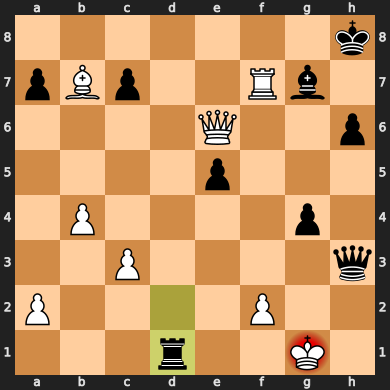

In [243]:
board

In [326]:
engine.analyse(board, chess.engine.Limit(time=0.1))["score"].white().wdl().expectation()

0.0

In [254]:
engine.analyse(board, chess.engine.Limit(time=0.1))

{'string': 'NNUE evaluation using nn-baff1ede1f90.nnue',
 'depth': 0,
 'score': PovScore(Mate(-0), WHITE)}

In [276]:
board.pop()

Move.from_uci('b3e6')

In [311]:
board.push(chess.Move.from_uci('h4h3'))

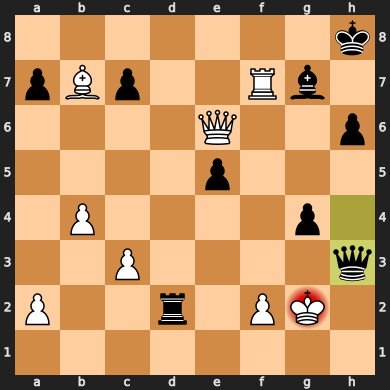

In [312]:
board